# Measurement of a 1D Profil with T1 time

In [1]:
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from main import measure, GAMMA
from helper import view, view_phase
import numba_ft

# Setup
## Load the sample2
This time the sample consists of two sub-samples with different  𝑇1  and  𝑇2 . They resemble oil and water. Two different versions of sample2 can be loaded.

1. sample2.npy Size  100×100 
2. sample2_modi.npy Size  300×300  

The second one takes a lot longer to simulate but the result resembles the reality far better. 
Since this simulation takes a lot of time itself the first one will be used.

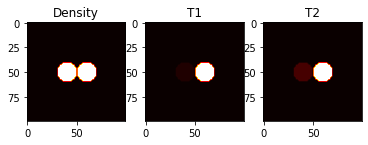

In [2]:
sample = np.load(f"{os.getcwd()}/sample2.npy")
view(sample)

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight inhomogeneity in the magnetic field necessary for spin echos.

In [3]:
b0 = np.zeros(sample.shape[:2])
b0.fill(0.43)
b0 += np.random.normal(0, 0.001, b0.shape)

f_larmor = GAMMA * 0.43

## Setup phases and measurement time

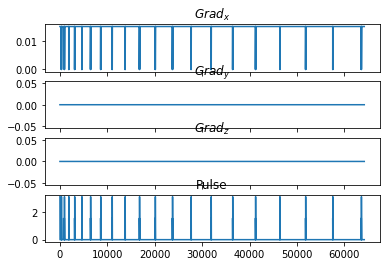

In [4]:
tfactor = 50
recotime = 6000  # ms Maximal recovery time between two measurements
echotime = 30  # ms
points = 20
recovery_time_step = recotime // points

t = points * 2 * echotime + recovery_time_step * ((points)**2 + (points)) // 2

# phases = [Gradx, Grady, Gradz, Pulse]
ts = np.linspace(0, t, t * tfactor)
phases = np.zeros((t * tfactor, 4))

# gradient in x
phases[:, 0] = 0.015

# pulses
phases[0, 3] = np.pi  # kill start magnetization
time = recovery_time_step

gets = []
for i in range(points):
    phases[tfactor * time, 3] = np.pi / 2  # 90 degree puls
    phases[tfactor * time, 0] = 0  # remove gradient at 90 degree puls
    
    time += echotime
    phases[tfactor * time, 3] = np.pi  # spin echo
    phases[tfactor * time, 0] = 0  # remove gradient at 180 degree puls
    gets.append(list(range(tfactor * (time + echotime - 10), 
                           tfactor * (time + echotime + 10))))
    time += recovery_time_step * (i + 2)
    
    


view_phase(phases, tfactor)

## Measure

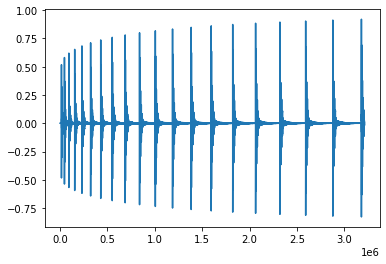

In [5]:
signal = measure(sample, b0, tfactor, phases, f_larmor)
plt.plot(signal)
plt.show()

## Results

In [6]:
f = np.linspace(0, 1000, 400, True)
times = [[e / tfactor * 1e-3 for e in get] for get in gets]
fft_signals = [np.abs(numba_ft.ft_uneven(signal[get], np.array(time), 2 * np.pi * f, 1, 0)) for get, time in zip(gets, times)]

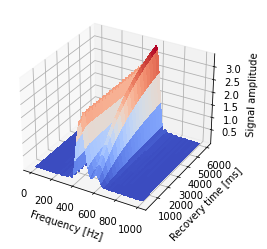

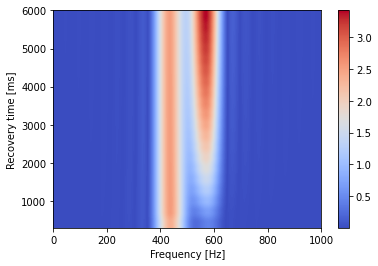

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fs, recotimes = np.meshgrid(f, np.array([recovery_time_step * (i + 1) for i in range(points)]))

# create 3D image
surf = ax.plot_surface(fs, recotimes, np.stack(fft_signals, axis=0), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Recovery time [ms]")
ax.set_zlabel("Signal amplitude")
plt.show()

# create top view image
plt.imshow(np.stack(fft_signals, axis=0)[::-1,:], cmap=cm.coolwarm, aspect='auto', 
           extent=[np.min(f), np.max(f), recovery_time_step, recotime])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Recovery time [ms]")
plt.colorbar()
plt.show()

The amplitude for the left signal stays equal for all recovery times. For the right signal the amplitude increases with the recovery time. Therefore, the left one is oil. It has a smaller $T_1$ time and thus is the magnetization into the z-direction already restored while for water it would take some more time. Increasesing the recovery time also the magnetization of water is restored and its signal increases. The result is consistent with the values we inserted into the sample.